# LSTM ile NDVI Zaman Serisi Tahmini

In [ ]:
from src.models.lstm_model import build_lstm_model

In [4]:
%pip install earthengine-api


  Using cached earthengine_api-1.5.15-py3-none-any.whl.metadata (2.1 kB)
  Using cached google_cloud_storage-3.1.0-py2.py3-none-any.whl.metadata (12 kB)
  Using cached google_api_python_client-2.169.0-py3-none-any.whl.metadata (6.7 kB)
  Using cached google_auth-2.40.1-py2.py3-none-any.whl.metadata (6.2 kB)
  Using cached google_auth_httplib2-0.2.0-py2.py3-none-any.whl.metadata (2.2 kB)
  Using cached httplib2-0.22.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached google_api_core-2.24.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached uritemplate-4.1.1-py2.py3-none-any.whl.metadata (2.9 kB)
  Using cached cachetools-5.5.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pyasn1_modules-0.4.2-py3-none-any.whl.metadata (3.5 kB)
  Using cached rsa-4.9.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached google_cloud_core-2.4.3-py2.py3-none-any.whl.metadata (2.7 kB)
  Using cached google_resumable_media-2.7.2-py2.py3-none-any.whl.metadata (2.2 kB)
  Using cached googleapis_common_protos-

In [6]:
import ee
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

# --- GEE Yetkilendirme ---
ee.Authenticate(auth_mode='notebook')
ee.Initialize()


Successfully saved authorization token.


In [12]:

from tensorflow.keras.initializers import Orthogonal
from dateutil.relativedelta import relativedelta
import datetime
import time

 Tahmin süresi: 0.08 saniye
 Son mevcut tahmin edilen NDVI: 0.2845
 Gelecek 5 ay tahmini:
  2023-03: 0.3239
  2023-04: 0.3159
  2023-05: 0.3005
  2023-06: 0.2875
  2023-07: 0.2797


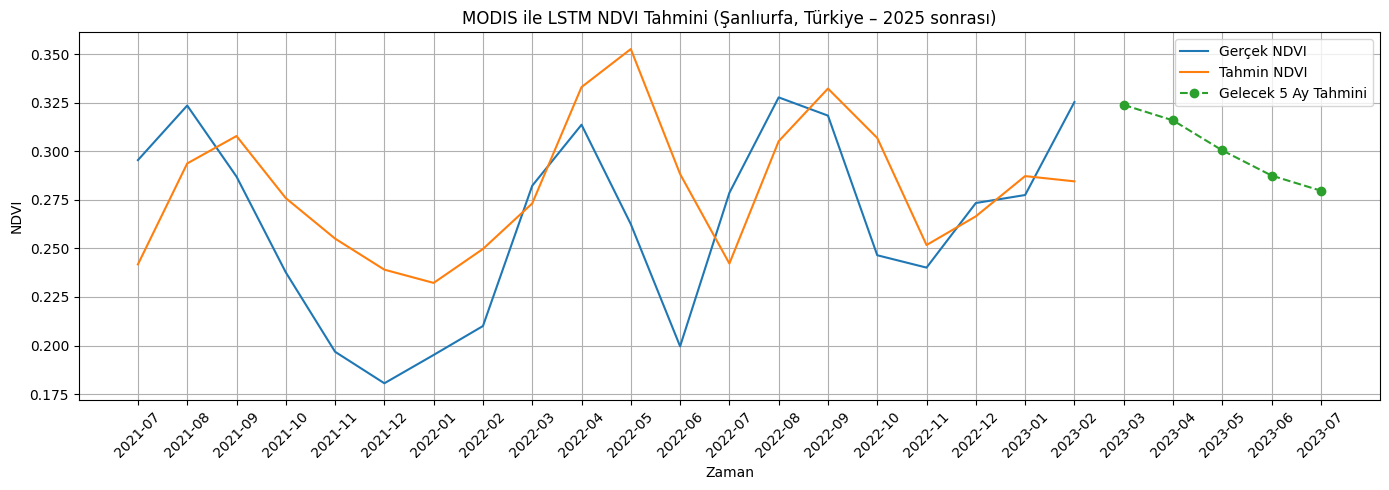

In [20]:
def get_monthly_modis_ndvi(region, start_year, end_year):
    collection = (ee.ImageCollection("MODIS/006/MOD13Q1")
                  .filterBounds(region)
                  .filterDate(f"{start_year}-01-01", f"{end_year}-12-31")
                  .select("NDVI"))

    ndvi_list = []
    for year in range(start_year, end_year + 1):
        for month in range(1, 13):
            monthly = collection \
                .filter(ee.Filter.calendarRange(month, month, 'month')) \
                .filter(ee.Filter.calendarRange(year, year, 'year')) \
                .mean()
            try:
                ndvi = monthly.reduceRegion(
                    reducer=ee.Reducer.mean(),
                    geometry=region,
                    scale=250,
                    maxPixels=1e13
                ).get("NDVI").getInfo()
                ndvi = ndvi / 10000.0 if ndvi is not None else None
            except:
                ndvi = None
            ndvi_list.append({'year': year, 'month': month, 'ndvi': ndvi})
    return pd.DataFrame(ndvi_list)

# --- Dataset oluşturma (LSTM için pencereleme) ---
def create_dataset(data, window_size=6):
    X = []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
    return np.array(X)

# --- Test bölgesi: Şanlıurfa çevresi ---
region = ee.Geometry.Rectangle([38.5, 36.5, 39.5, 37.5])

# --- 2021–2025 arası NDVI verisini çek ---
ndvi_df = get_monthly_modis_ndvi(region, 2021, 2025)
ndvi_df.dropna(inplace=True)
if ndvi_df.empty:
    raise ValueError(" NDVI verisi bulunamadı. Bölgeyi değiştirin.")

# --- NDVI verisini ölçekle ---
ndvi = ndvi_df["ndvi"].values.reshape(-1, 1)
scaler = MinMaxScaler()
ndvi_scaled = scaler.fit_transform(ndvi)

# --- Model verisi oluştur ---
window_size = 6
X = create_dataset(ndvi_scaled, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1, 1))  # (samples, time, features, extra)

# --- Modeli yükle ---
model_path = "/Users/ahmetbekir/AI-Driven-Food-Crisis-Prediction-Using-Satellite-And-Climate-Data/models/lstm_ndvi_model.h5"
model = load_model(model_path, compile=False, custom_objects={'Orthogonal': Orthogonal})

# --- Model tahmini (geçmiş veri üzerinden) ---
start = time.time()
y_pred = model.predict(X, verbose=0)
end = time.time()
elapsed = end - start
y_pred_inv = scaler.inverse_transform(y_pred)

# --- Recursive tahmin (gelecek 5 ay) ---
future_months = 5
last_window = ndvi_scaled[-window_size:].reshape(1, window_size, 1, 1)
future_preds_scaled = []

for _ in range(future_months):
    pred = model.predict(last_window, verbose=0)
    future_preds_scaled.append(pred[0][0])
    last_window = np.concatenate([last_window[:, 1:, :, :], pred.reshape(1, 1, 1, 1)], axis=1)

future_preds = scaler.inverse_transform(np.array(future_preds_scaled).reshape(-1, 1))

# --- Tarih etiketleri oluştur ---
date_labels = [f"{int(row['year'])}-{int(row['month']):02d}" for _, row in ndvi_df.iloc[window_size:].iterrows()]
last_year = int(ndvi_df['year'].iloc[-1])
last_month = int(ndvi_df['month'].iloc[-1])
last_date = datetime.date(last_year, last_month, 1)
future_dates = [last_date + relativedelta(months=i+1) for i in range(future_months)]
future_labels = [d.strftime("%Y-%m") for d in future_dates]

# --- Çıktı ---
print(f" Tahmin süresi: {elapsed:.2f} saniye")
print(f" Son mevcut tahmin edilen NDVI: {y_pred_inv[-1][0]:.4f}")
print(" Gelecek 5 ay tahmini:")
for label, val in zip(future_labels, future_preds):
    print(f"  {label}: {val[0]:.4f}")

# --- Grafik ---
plt.figure(figsize=(14, 5))
plt.plot(date_labels, ndvi[window_size:], label="Gerçek NDVI")
plt.plot(date_labels, y_pred_inv, label="Tahmin NDVI")
plt.plot(future_labels, future_preds, label="Gelecek 5 Ay Tahmini", linestyle="--", marker='o')
plt.title("MODIS ile LSTM NDVI Tahmini (Şanlıurfa, Türkiye – 2025 sonrası)")
plt.xlabel("Zaman")
plt.ylabel("NDVI")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
import sys
import os
sys.path.append(os.path.abspath("..")) 


In [31]:
import ee
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
from tensorflow.keras.initializers import Orthogonal
from src.gee.data_loader import get_monthly_ndvi
from dateutil.relativedelta import relativedelta

📥 NDVI verisi indiriliyor...
✅ NDVI verisi başarıyla alındı.
📦 Model yükleniyor...
✅ Model yüklendi.
🔮 2025 Haziran sonrası 5 ay tahmini başlıyor...


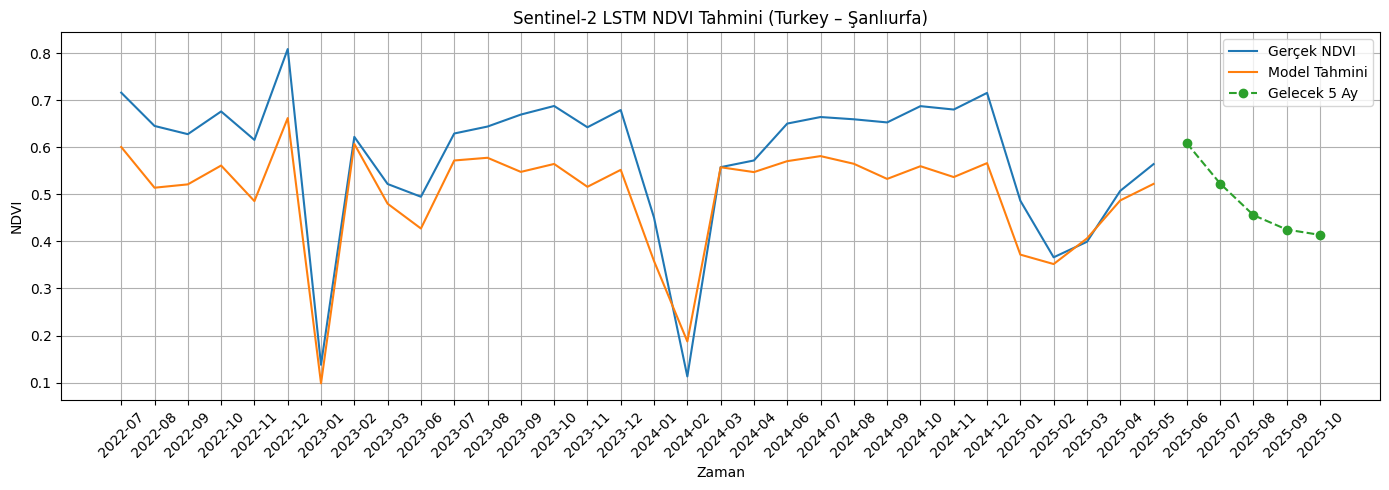

📅 Gelecek 5 ay tahmini:
2025-06: 0.6086
2025-07: 0.5229
2025-08: 0.4558
2025-09: 0.4252
2025-10: 0.4138


In [35]:
# --- Parametreler ---
country = "Germany"
scale = 10
window_size = 6
future_months = 5

# --- Bölge: Şanlıurfa çevresi ---
#region = ee.Geometry.Rectangle([38.5, 36.5, 39.5, 37.5])
region = ee.Geometry.Rectangle([11.2, 47.9, 12.0, 48.4])  # Almanya - Münih çevresi

# --- NDVI verisini çek (Sentinel-2) ---
print("📥 NDVI verisi indiriliyor...")
ndvi_df = get_monthly_ndvi(region, start_year=2022, end_year=2025, scale=scale)
ndvi_df.dropna(inplace=True)
print("✅ NDVI verisi başarıyla alındı.")

# --- Zaman serisi verisine çevir ---
ndvi_df["date"] = pd.to_datetime(ndvi_df["year"].astype(str) + "-" + ndvi_df["month"].astype(str) + "-01")
ndvi_df["date_str"] = ndvi_df["date"].dt.strftime("%Y-%m")
ndvi = ndvi_df["ndvi"].values.reshape(-1, 1)

# --- Ölçekleme ---
scaler = MinMaxScaler()
ndvi_scaled = scaler.fit_transform(ndvi)

# # --- Dataset oluştur ---
# X = []
# for i in range(len(ndvi_scaled) - window_size):
#     X.append(ndvi_scaled[i:i+window_size])
# X = np.array(X).reshape(-1, window_size, 1)
# --- Dataset oluştur ---
X = []
for i in range(len(ndvi_scaled) - window_size):
    X.append(ndvi_scaled[i:i+window_size])
X = np.array(X).reshape(-1, window_size, 1)

# EKSİK: Gerçek NDVI hedefleri
y = ndvi_scaled[window_size:]  # Her pencerenin sonrası


# --- Modeli yükle ---
print("📦 Model yükleniyor...")
model_path = "/Users/ahmetbekir/AI-Driven-Food-Crisis-Prediction-Using-Satellite-And-Climate-Data/models/lstm_ndvi_model.h5"
model = load_model(model_path, compile=False, custom_objects={'Orthogonal': Orthogonal})
print("✅ Model yüklendi.")

# --- Geçmiş tahmini ---
y_pred = model.predict(X, verbose=0)
y_pred_inv = scaler.inverse_transform(y_pred)

# --- Gelecek 5 ay tahmini ---
print("🔮 2025 Haziran sonrası 5 ay tahmini başlıyor...")
last_window = ndvi_scaled[-window_size:].reshape(1, window_size, 1)
future_preds_scaled = []

for _ in range(future_months):
    pred = model.predict(last_window, verbose=0)
    future_preds_scaled.append(pred[0][0])
    last_window = np.concatenate([last_window[:, 1:, :], pred.reshape(1, 1, 1)], axis=1)

future_preds = scaler.inverse_transform(np.array(future_preds_scaled).reshape(-1, 1))

# --- Gelecek tarih etiketleri ---
last_date = ndvi_df["date"].max()
future_dates = [last_date + relativedelta(months=i+1) for i in range(future_months)]
future_labels = [d.strftime("%Y-%m") for d in future_dates]

# --- Grafik ---
plt.figure(figsize=(14, 5))
plt.plot(ndvi_df["date_str"][window_size:], scaler.inverse_transform(X.reshape(-1, window_size))[:, -1], label="Gerçek NDVI")
plt.plot(ndvi_df["date_str"][window_size:], y_pred_inv, label="Model Tahmini")
plt.plot(future_labels, future_preds, label="Gelecek 5 Ay", linestyle="--", marker='o')
plt.title(f"Sentinel-2 LSTM NDVI Tahmini ({country} – Munih)")
plt.xlabel("Zaman")
plt.ylabel("NDVI")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Çıktı ---
print("📅 Gelecek 5 ay tahmini:")
for label, val in zip(future_labels, future_preds):
    print(f"{label}: {val[0]:.4f}")

In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Gerçek ve tahmin verileri (ölçeklenmemiş)
# y_true_inv = scaler.inverse_transform(ndvi_scaled[window_size:])  # Gerçek NDVI (tahmin edilen aralık)
# y_pred_inv = scaler.inverse_transform(y_pred)                      # Modelin tahmini
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_true_inv = scaler.inverse_transform(y.reshape(-1, 1))

# --- Metrikler ---
mae = mean_absolute_error(y_true_inv, y_pred_inv)
mse = mean_squared_error(y_true_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_inv, y_pred_inv)

# --- Çıktı ---
print("\n📊 Model Performans Metrikleri:")
print(f"MAE  (Ortalama Mutlak Hata): {mae:.4f}")
print(f"MSE  (Karesel Ortalama Hata): {mse:.4f}")
print(f"RMSE (Kök Ortalama Hata)    : {rmse:.4f}")
print(f"R²   (Doğruluk Skoru)        : {r2:.4f}")



📊 Model Performans Metrikleri:
MAE  (Ortalama Mutlak Hata): 0.1435
MSE  (Karesel Ortalama Hata): 0.0365
RMSE (Kök Ortalama Hata)    : 0.1910
R²   (Doğruluk Skoru)        : -0.6288


In [44]:
print(ndvi_df["ndvi"].describe())


count    38.000000
mean      0.576723
std       0.143629
min       0.113048
25%       0.512954
50%       0.628587
75%       0.668193
max       0.808746
Name: ndvi, dtype: float64


📥 NDVI verisi indiriliyor...
✅ NDVI verisi başarıyla alındı.
📦 Model yükleniyor...
✅ Model yüklendi.
🔮 2025 Haziran sonrası 5 ay tahmini başlıyor...


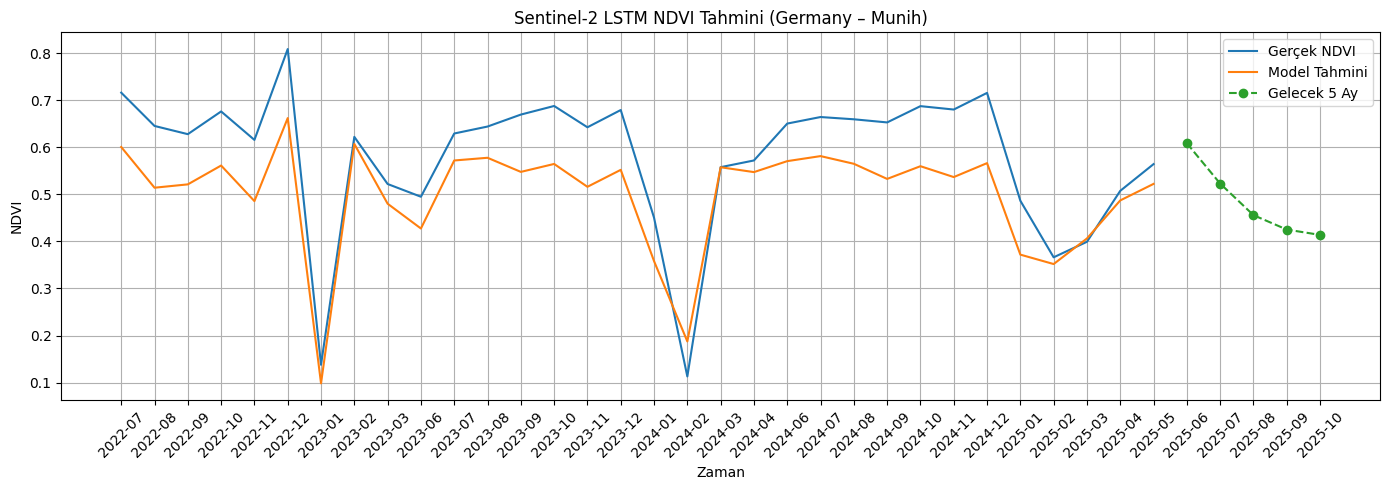

📅 Gelecek 5 ay tahmini:
2025-06: 0.6086
2025-07: 0.5229
2025-08: 0.4558
2025-09: 0.4252
2025-10: 0.4138


In [43]:
# --- Parametreler ---
country = "Germany"
scale = 10
window_size = 6
future_months = 5

# --- Bölge: Şanlıurfa çevresi ---
#region = ee.Geometry.Rectangle([38.5, 36.5, 39.5, 37.5])
#region = ee.Geometry.Rectangle([11.2, 47.9, 12.0, 48.4])  # Almanya - Münih çevresi
region = ee.Geometry.Rectangle([10.0, 47.0, 13.5, 49.5])  # Bavyera (genişletilmiş alan)

# --- NDVI verisini çek (Sentinel-2) ---
print("📥 NDVI verisi indiriliyor...")
ndvi_df = get_monthly_ndvi(region, start_year=2022, end_year=2025, scale=scale)
ndvi_df.dropna(inplace=True)
print("✅ NDVI verisi başarıyla alındı.")

# --- Zaman serisi verisine çevir ---
ndvi_df["date"] = pd.to_datetime(ndvi_df["year"].astype(str) + "-" + ndvi_df["month"].astype(str) + "-01")
ndvi_df["date_str"] = ndvi_df["date"].dt.strftime("%Y-%m")
ndvi = ndvi_df["ndvi"].values.reshape(-1, 1)

# --- Ölçekleme ---
scaler = MinMaxScaler()
ndvi_scaled = scaler.fit_transform(ndvi)

# # --- Dataset oluştur ---
# X = []
# for i in range(len(ndvi_scaled) - window_size):
#     X.append(ndvi_scaled[i:i+window_size])
# X = np.array(X).reshape(-1, window_size, 1)
# --- Dataset oluştur ---
X = []
for i in range(len(ndvi_scaled) - window_size):
    X.append(ndvi_scaled[i:i+window_size])
X = np.array(X).reshape(-1, window_size, 1)

# EKSİK: Gerçek NDVI hedefleri
y = ndvi_scaled[window_size:]  # Her pencerenin sonrası


# --- Modeli yükle ---
print("📦 Model yükleniyor...")
model_path = "/Users/ahmetbekir/AI-Driven-Food-Crisis-Prediction-Using-Satellite-And-Climate-Data/models/lstm_ndvi_model.h5"
model = load_model(model_path, compile=False, custom_objects={'Orthogonal': Orthogonal})
print("✅ Model yüklendi.")

# --- Geçmiş tahmini ---
y_pred = model.predict(X, verbose=0)
y_pred_inv = scaler.inverse_transform(y_pred)

# --- Gelecek 5 ay tahmini ---
print("🔮 2025 Haziran sonrası 5 ay tahmini başlıyor...")
last_window = ndvi_scaled[-window_size:].reshape(1, window_size, 1)
future_preds_scaled = []

for _ in range(future_months):
    pred = model.predict(last_window, verbose=0)
    future_preds_scaled.append(pred[0][0])
    last_window = np.concatenate([last_window[:, 1:, :], pred.reshape(1, 1, 1)], axis=1)

future_preds = scaler.inverse_transform(np.array(future_preds_scaled).reshape(-1, 1))

# --- Gelecek tarih etiketleri ---
last_date = ndvi_df["date"].max()
future_dates = [last_date + relativedelta(months=i+1) for i in range(future_months)]
future_labels = [d.strftime("%Y-%m") for d in future_dates]

# --- Grafik ---
plt.figure(figsize=(14, 5))
plt.plot(ndvi_df["date_str"][window_size:], scaler.inverse_transform(X.reshape(-1, window_size))[:, -1], label="Gerçek NDVI")
plt.plot(ndvi_df["date_str"][window_size:], y_pred_inv, label="Model Tahmini")
plt.plot(future_labels, future_preds, label="Gelecek 5 Ay", linestyle="--", marker='o')
plt.title(f"Sentinel-2 LSTM NDVI Tahmini ({country} – Munih)")
plt.xlabel("Zaman")
plt.ylabel("NDVI")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Çıktı ---
print("📅 Gelecek 5 ay tahmini:")
for label, val in zip(future_labels, future_preds):
    print(f"{label}: {val[0]:.4f}")

In [49]:
# --- Performans Metrikleri ---
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# y_true ve y_pred boyutları uyumlu olmalı, inverse transform uygulanmalı
y_true_inv = scaler.inverse_transform(y.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

mae = mean_absolute_error(y_true_inv, y_pred_inv)
mse = mean_squared_error(y_true_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = 1 - (np.sum((y_true_inv - y_pred_inv)**2) / np.sum((y_true_inv - np.mean(y_true_inv))**2))

print("\n📊 Model Performans Metrikleri:")
print(f"MAE  (Ortalama Mutlak Hata): {mae:.4f}")
print(f"MSE  (Karesel Ortalama Hata): {mse:.4f}")
print(f"RMSE (Kök Ortalama Hata)    : {rmse:.4f}")
print(f"R²   (Doğruluk Skoru)        : {r2:.4f}")



📊 Model Performans Metrikleri:
MAE  (Ortalama Mutlak Hata): 0.1435
MSE  (Karesel Ortalama Hata): 0.0365
RMSE (Kök Ortalama Hata)    : 0.1910
R²   (Doğruluk Skoru)        : -0.6288


📥 NDVI verisi indiriliyor...
✅ NDVI verisi başarıyla alındı.
📦 Model yükleniyor...
✅ Model yüklendi.
🔮 2025 Haziran sonrası 5 ay tahmini başlıyor...


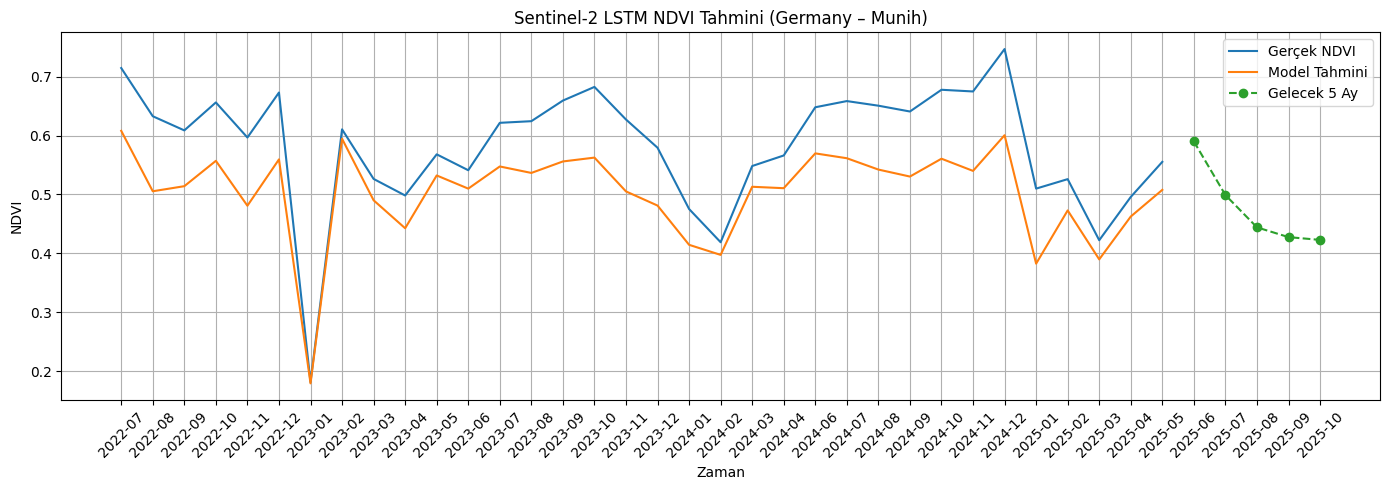

📅 Gelecek 5 ay tahmini:
2025-06: 0.5901
2025-07: 0.4990
2025-08: 0.4442
2025-09: 0.4276
2025-10: 0.4228


In [50]:
# --- Parametreler ---
country = "Germany"
scale = 10
window_size = 6
future_months = 5

# --- Bölge: Şanlıurfa çevresi ---
#region = ee.Geometry.Rectangle([38.5, 36.5, 39.5, 37.5])
#region = ee.Geometry.Rectangle([11.2, 47.9, 12.0, 48.4])  # Almanya - Münih çevresi
region = ee.Geometry.Rectangle([10.0, 47.0, 13.5, 49.5])  # Bavyera (genişletilmiş alan)

# --- NDVI verisini çek (Sentinel-2) ---
print("📥 NDVI verisi indiriliyor...")
ndvi_df = get_monthly_ndvi(region, start_year=2022, end_year=2025, scale=scale)
ndvi_df.dropna(inplace=True)
print("✅ NDVI verisi başarıyla alındı.")

# --- Zaman serisi verisine çevir ---
ndvi_df["date"] = pd.to_datetime(ndvi_df["year"].astype(str) + "-" + ndvi_df["month"].astype(str) + "-01")
ndvi_df["date_str"] = ndvi_df["date"].dt.strftime("%Y-%m")
ndvi = ndvi_df["ndvi"].values.reshape(-1, 1)

# --- Ölçekleme ---
scaler = MinMaxScaler()
ndvi_scaled = scaler.fit_transform(ndvi)

# # --- Dataset oluştur ---
# X = []
# for i in range(len(ndvi_scaled) - window_size):
#     X.append(ndvi_scaled[i:i+window_size])
# X = np.array(X).reshape(-1, window_size, 1)
# --- Dataset oluştur ---
X = []
for i in range(len(ndvi_scaled) - window_size):
    X.append(ndvi_scaled[i:i+window_size])
X = np.array(X).reshape(-1, window_size, 1)

# EKSİK: Gerçek NDVI hedefleri
y = ndvi_scaled[window_size:]  # Her pencerenin sonrası


# --- Modeli yükle ---
print("📦 Model yükleniyor...")
model_path = "/Users/ahmetbekir/AI-Driven-Food-Crisis-Prediction-Using-Satellite-And-Climate-Data/models/lstm_ndvi_model.h5"
model = load_model(model_path, compile=False, custom_objects={'Orthogonal': Orthogonal})
print("✅ Model yüklendi.")

# --- Geçmiş tahmini ---
y_pred = model.predict(X, verbose=0)
y_pred_inv = scaler.inverse_transform(y_pred)

# --- Gelecek 5 ay tahmini ---
print("🔮 2025 Haziran sonrası 5 ay tahmini başlıyor...")
last_window = ndvi_scaled[-window_size:].reshape(1, window_size, 1)
future_preds_scaled = []

for _ in range(future_months):
    pred = model.predict(last_window, verbose=0)
    future_preds_scaled.append(pred[0][0])
    last_window = np.concatenate([last_window[:, 1:, :], pred.reshape(1, 1, 1)], axis=1)

future_preds = scaler.inverse_transform(np.array(future_preds_scaled).reshape(-1, 1))

# --- Gelecek tarih etiketleri ---
last_date = ndvi_df["date"].max()
future_dates = [last_date + relativedelta(months=i+1) for i in range(future_months)]
future_labels = [d.strftime("%Y-%m") for d in future_dates]

# --- Grafik ---
plt.figure(figsize=(14, 5))
plt.plot(ndvi_df["date_str"][window_size:], scaler.inverse_transform(X.reshape(-1, window_size))[:, -1], label="Gerçek NDVI")
plt.plot(ndvi_df["date_str"][window_size:], y_pred_inv, label="Model Tahmini")
plt.plot(future_labels, future_preds, label="Gelecek 5 Ay", linestyle="--", marker='o')
plt.title(f"Sentinel-2 LSTM NDVI Tahmini ({country} – Munih)")
plt.xlabel("Zaman")
plt.ylabel("NDVI")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Çıktı ---
print("📅 Gelecek 5 ay tahmini:")
for label, val in zip(future_labels, future_preds):
    print(f"{label}: {val[0]:.4f}")

In [51]:
# --- Performans Metrikleri ---
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# y_true ve y_pred boyutları uyumlu olmalı, inverse transform uygulanmalı
y_true_inv = scaler.inverse_transform(y.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

mae = mean_absolute_error(y_true_inv, y_pred_inv)
mse = mean_squared_error(y_true_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = 1 - (np.sum((y_true_inv - y_pred_inv)**2) / np.sum((y_true_inv - np.mean(y_true_inv))**2))

print("\n📊 Model Performans Metrikleri:")
print(f"MAE  (Ortalama Mutlak Hata): {mae:.4f}")
print(f"MSE  (Karesel Ortalama Hata): {mse:.4f}")
print(f"RMSE (Kök Ortalama Hata)    : {rmse:.4f}")
print(f"R²   (Doğruluk Skoru)        : {r2:.4f}")



📊 Model Performans Metrikleri:
MAE  (Ortalama Mutlak Hata): 0.1127
MSE  (Karesel Ortalama Hata): 0.0206
RMSE (Kök Ortalama Hata)    : 0.1436
R²   (Doğruluk Skoru)        : -0.9306


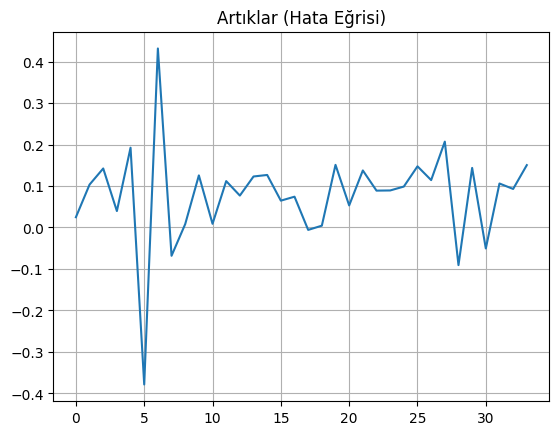

In [52]:
import matplotlib.pyplot as plt

residuals = y_true_inv.flatten() - y_pred_inv.flatten()
plt.plot(residuals)
plt.title("Artıklar (Hata Eğrisi)")
plt.grid()
plt.show()


In [54]:
import ee
import os
import pandas as pd
from src.gee.ndvi_utils import mask_s2_clouds, add_ndvi

# Earth Engine başlat
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize()

# 📁 Kayıt klasörü
os.makedirs("ndvi_data", exist_ok=True)

# 🌍 13 Bölge ve koordinatlar
regions = {
   
    "iowa": ee.Geometry.Rectangle([-94.0, 42.0, -93.0, 43.0]),
    "zacatecas": ee.Geometry.Rectangle([-103.0, 22.0, -102.0, 23.0]),
    "mato_grosso": ee.Geometry.Rectangle([-56.0, -13.0, -55.0, -12.0]),
  
}

# 🔽 NDVI indirici fonksiyon
def get_monthly_ndvi(geom, start_year, end_year, scale, buffer_radius=50000):
    results = []
    reduced_geom = geom.centroid().buffer(buffer_radius)
    for year in range(start_year, end_year + 1):
        for month in range(1, 13):
            start_date = f"{year}-{month:02d}-01"
            end_date = f"{year}-{month:02d}-28"
            image = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                     .filterDate(start_date, end_date)
                     .filterBounds(reduced_geom)
                     .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
                     .map(mask_s2_clouds)
                     .map(add_ndvi)
                     .median())
            try:
                ndvi = image.select('NDVI').reduceRegion(
                    reducer=ee.Reducer.mean(),
                    geometry=reduced_geom,
                    scale=scale,
                    maxPixels=1e13
                ).getInfo().get('NDVI')
            except Exception:
                ndvi = None
            results.append({"year": year, "month": month, "ndvi": ndvi})
    return pd.DataFrame(results)

# 📥 Her bölge için veri indir ve kaydet
for name, geom in regions.items():
    save_path = f"ndvi_data/ndvi_{name}.csv"
    if os.path.exists(save_path):
        print(f"✅ {name}: Zaten mevcut, atlanıyor.")
        continue
    print(f"📡 {name}: NDVI verisi indiriliyor...")
    df = get_monthly_ndvi(geom, start_year=2020, end_year=2025, scale=10)
    df.dropna(inplace=True)
    df.to_csv(save_path, index=False)
    print(f"💾 {name}: Kaydedildi → {save_path}")


📡 iowa: NDVI verisi indiriliyor...
💾 iowa: Kaydedildi → ndvi_data/ndvi_iowa.csv
📡 zacatecas: NDVI verisi indiriliyor...
